In [374]:
#ds=xr.Dataset({'zKuObs':zKuObs_Strat_xr,'zKaObs':zKaObs_Strat_xr,'binZeroDeg':binZeroDeg_Strat_xr,'pia_HB_DPR':pia_HB_DPR_strat_xr,'pia_HB_CMB':pia_HB_CMB_strat_xr,'binClutterFree':binClutterFree_Strat_xr,'binRealSurface':binRealSurface_Strat_xr,'jRay':jRay_Strat_xr,'logdNw':logdNw_Strat_xr,'binStormTop':binStormTop_Strat_xr,'nearSurfPrecipTotRate':nearSurfPrecipTotRate_Strat_xr})

import numpy as np
import netCDF4 as nc
with nc.Dataset('../ROSES2024/data/convective_training_data_ext.nc','r') as ncf:
    zKuObs = ncf['zKuObs'][:]
    zKaObs = ncf['zKaObs'][:]
    binZeroDeg = ncf['binZeroDeg'][:]
    pia_HB_DPR = ncf['pia_HB_DPR'][:]
    pia_HB_CMB = ncf['pia_HB_CMB'][:]
    binClutterFree = ncf['binClutterFree'][:]
    binRealSurface = ncf['binRealSurface'][:]
    jRay = ncf['jRay'][:]
    logdNw= ncf['logdNw'][:]
    binStormTop= ncf['binStormTop'][:]
    nearSurfPrecipTotRate = ncf['nearSurfPrecipTotRate'][:]
    precipTotRate=ncf['precipTotRate'][:]
    dmTotCMB=ncf['dmTotCMB'][:]
    srtPIA = ncf['srtPIAKu'][:,0]
n_bins_L=[]


In [3]:
print(binZeroDeg.mean())
dn_mean=np.log10(0.08e8)
print(dn_mean)


142.35338316693395
6.903089986991944


In [380]:
dbinL=[]
zmL=[]
log10dNL=[]
icount=0
nSeq_train_L=[]
x_train_L=[]
y_train_L=[]
nSeq_val_L=[]
x_val_L=[]
y_val_L=[]
ic=0
dmTotCMB[dmTotCMB<0]=0
for i in range(zKaObs.shape[0]):
    n_bins_prof=binClutterFree[i]-binStormTop[i]
    n_bins_L.append(n_bins_prof)
    top=binStormTop[i]
    bot=binClutterFree[i]
    top2=binStormTop[i]//2
    bot2=binClutterFree[i]//2
    zm1=np.log10((10**(0.1*zKuObs[i,2*top2:2*bot2][::2])+10**(0.1*zKuObs[i,2*top2:2*bot2+1][1::2])+1e-3)/2)*10
    zm1[zm1<0]=0
    zmL.extend(zm1)
    log10dN_cmb=logdNw[i,top2:bot2]
    log10dN_cmb[log10dN_cmb<0]=6.9
    log10dNL.extend(log10dN_cmb-6.9)
    dbin=(np.arange(top2,bot2)-binZeroDeg[i]//2)
    precipCMB1=precipTotRate[i,top2:bot2]
    if ic%100<66:
        x_train_L.append([(zm1-27)/8.,dbin/23.0,log10dN_cmb-6.9,precipCMB1,dmTotCMB[i,top2:bot2]])
        y_train_L.append([log10dN_cmb-6.9,pia_HB_CMB[i,0],nearSurfPrecipTotRate[i]])  
        nSeq_train_L.append((bot2-top2))
    else:
        x_val_L.append([(zm1-27)/8.,dbin/23.0,log10dN_cmb-6.9,precipCMB1,dmTotCMB[i,top2:bot2]])
        y_val_L.append([log10dN_cmb-6.9,pia_HB_CMB[i,0],nearSurfPrecipTotRate[i]])  
        nSeq_val_L.append((bot2-top2))
    if bot2-top2>80:
        print(bot2,top2)
        break
    dbinL.extend(dbin/23)
    ic+=1
    if zm1.shape[0]==log10dN_cmb.shape[0]:
        icount+=1
print(icount,ic)

77324 77324


In [381]:
n_seq_max=max(np.max(nSeq_train_L),np.max(nSeq_val_L))
x_train_padded=[]
y_train_seq_padded=[]
y_train_scalar=[]
n_seq_train=[]
n_seq_val=[]
x_val_padded=[]
y_val_seq_padded=[]
y_val_scalar=[]
for i,nseq in enumerate(nSeq_train_L):
    if nseq<1:
        continue
    x1_train=np.zeros((n_seq_max,5))
    x1_train[:nseq,0]=x_train_L[i][0]
    x1_train[:nseq,1]=x_train_L[i][1]
    x1_train[:nseq,2]=x_train_L[i][2]
    x1_train[:nseq,3]=x_train_L[i][3]
    x1_train[:nseq,4]=x_train_L[i][4]
    x_train_padded.append(x1_train)
    y1=np.zeros((n_seq_max,2))
    y1[:nseq,0]=y_train_L[i][0]
    y1[:nseq,1]=np.log10(1+x_train_L[i][3]/0.1)
    y_train_seq_padded.append(y1)
    y_train_scalar.append([np.log10(1+y_train_L[i][1])*3,np.log10(1+y_train_L[i][2]/0.1)])
    n_seq_train.append(nseq)

for i, nseq in enumerate(nSeq_val_L):
    if nseq<1:
        continue
    x1_val=np.zeros((n_seq_max,5))
    x1_val[:nseq,0]=x_val_L[i][0]
    x1_val[:nseq,1]=x_val_L[i][1]
    x1_val[:nseq,2]=x_val_L[i][2]
    x1_val[:nseq,3]=x_val_L[i][3]
    x1_val[:nseq,4]=x_val_L[i][4]
    x_val_padded.append(x1_val)
    y1=np.zeros((n_seq_max,2))
    y1[:nseq,0]=y_val_L[i][0]
    y1[:nseq,1]=np.log10(1+x_val_L[i][3]/0.1)
    y_val_seq_padded.append(y1)
    y_val_scalar.append([np.log10(1+y_val_L[i][1])*3,np.log10(1+y_val_L[i][2]/0.1)])
    n_seq_val.append(nseq)

In [383]:
y_train_seq_padded=np.array(y_train_seq_padded)
y_train_scalar=np.array(y_train_scalar)
x_train_padded=np.array(x_train_padded)
n_seq_train=np.array(n_seq_train)
y_val_seq_padded=np.array(y_val_seq_padded)
y_val_scalar=np.array(y_val_scalar)
x_val_padded=np.array(x_val_padded)
n_seq_val=np.array(n_seq_val)

print(x_train_padded[:,:,-1].min())
print(x_train_padded[:,:,-1].max())


0.0
4.26629114151001


In [385]:
from sklearn.cluster import KMeans
nc_knn=120
kmeans = KMeans(n_clusters=nc_knn, random_state=0)
nz=padded_input.shape[1]
kmeans.fit(x_train_padded[:,:,0:2].reshape(-1,2*nz))

KMeans(n_clusters=120, random_state=0)

In [365]:
from sklearn.mixture import GaussianMixture
nc_gmm=60
kmeans_gmm = KMeans(n_clusters=nc_gmm, random_state=0)
nz=padded_input.shape[1]
kmeans_gmm.fit(x_train_padded[:,:,0:2].reshape(-1,2*nz))
nc_gmm = 60
gmm = GaussianMixture(n_components=nc_gmm, init_params='random', random_state=0)
nz = padded_input.shape[1]
gmm.fit(x_train_padded[:,:,0:2].reshape(-1, 2*nz))

GaussianMixture(init_params='random', n_components=60, random_state=0)

In [366]:
#gmmpred = gmm.predict(x_train_padded[:,:,0:2].reshape(-1, 2*nz))
#print(gmmpred.shape)
#print(gmmpred[0:100])
#gmm_proba=gmm.predict_proba(x_train_padded[:,:,0:2].reshape(-1, 2*nz))
import pickle
with open('gmm_60.pkl','wb') as f:
    pickle.dump(gmm,f)
gmm_classes=gmm.predict(x_train_padded[:,:,0:2].reshape(-1, 2*nz))

In [367]:
for i in range(nc_gmm):
    print(i,np.sum(gmm_classes==i))

0 327
1 35
2 313
3 20
4 19
5 547
6 156
7 1523
8 2715
9 2309
10 975
11 2556
12 140
13 129
14 945
15 970
16 165
17 956
18 913
19 190
20 1047
21 31
22 752
23 775
24 43
25 345
26 726
27 30
28 21
29 24
30 206
31 31
32 538
33 101
34 985
35 1129
36 48
37 1727
38 34
39 38
40 869
41 48
42 2273
43 38
44 767
45 29
46 45
47 896
48 773
49 13
50 830
51 1477
52 1518
53 41
54 60
55 13577
56 2815
57 39
58 9
59 87


In [369]:
sfcPrecipClass=[]
ncounts=[]
# import rigde regression model
from sklearn.linear_model import Ridge
rigdRegModels=[]
x_train_padded[x_train_padded<-90]=0
x_val_padded[x_val_padded<-90]=0
ymClass_gmm=[]
xmClass_gmm=[]
kgainClass_gmm=[]
n_seq_max_Class_gmm=[]
nf=2
for i in range(nc_gmm):
    a=np.where(gmm_classes==i)
    n_seq_max_a=np.max(n_seq_train[a])
    n_seq_max_Class_gmm.append(n_seq_max_a)
    sfcPrecipClass.append(y_train_scalar[:,1][a].mean())
    y1=x_train_padded[a][:,:n_seq_max_a,0:nf].reshape(-1,nf*n_seq_max_a)
    x1=x_train_padded[a][:,:n_seq_max_a,3].reshape(-1,n_seq_max_a)
    covXY_=np.cov(x1.T,y1.T)
    covYY=covXY_[n_seq_max_a:,n_seq_max_a:]+0.025*np.eye(nf*n_seq_max_a)
    covXY=covXY_[:n_seq_max_a,n_seq_max_a:]
    kgain=np.dot(covXY,np.linalg.pinv(covYY))
    xmClass_gmm.append(x1.mean(axis=0))
    ymClass_gmm.append(y1.mean(axis=0))
    kgainClass_gmm.append(kgain)


gmm_labels=gmm.predict(x_val_padded[:,:,0:2].reshape(-1,2*nz))
predL=[]
validL=[]
for i, x_val in enumerate(x_val_padded):
    a=np.where(gmm_labels==i)
    n_seq_max_a=n_seq_max_Class_gmm[gmm_labels[i]]
    y1=x_val[:n_seq_max_a,0:nf].reshape(nf*n_seq_max_a)
    x1=x_val[:n_seq_max_a,3].reshape(n_seq_max_a)

    x1_pred=xmClass_gmm[gmm_labels[i]]+np.dot(kgainClass_gmm[gmm_labels[i]],y1-ymClass_gmm[gmm_labels[i]])
    #x1_pred[x1_pred<0]=0
    if n_seq_val[i]<n_seq_max_a:
        x1_pred[n_seq_val[i]:]=0
    predL.extend(x1_pred[:n_seq_max_a])
    validL.extend(x1[:n_seq_max_a])
    #y1[:,1]=sfcPrecipClass[i]
    #y_val_seq_padded[i]=y1
print(np.corrcoef(np.array(predL).flatten(),np.array(validL).flatten()))

[[1.         0.78798664]
 [0.78798664 1.        ]]


(array([693]),)


In [422]:
sfcPrecipClass=[]
ncounts=[]
# import rigde regression model
from sklearn.linear_model import Ridge
rigdRegModels=[]
x_train_padded[x_train_padded<-90]=0
x_val_padded[x_val_padded<-90]=0
ymClass=[]
xmClass=[]
kgainClass=[]
n_seq_max_Class=[]
cov_error_Class=[]
mean_error_Class=[]
nf=2
for i in range(nc_knn):
    a=np.where(kmeans.labels_==i)
    n_seq_max_a=np.max(n_seq_train[a])
    n_seq_max_Class.append(n_seq_max_a)
    sfcPrecipClass.append(y_train_scalar[:,1][a].mean())
    y1=x_train_padded[a][:,:n_seq_max_a,0:nf].reshape(-1,nf*n_seq_max_a)
    x1_1=x_train_padded[a][:,:n_seq_max_a,2].reshape(-1,n_seq_max_a)
    x1_2=x_train_padded[a][:,:n_seq_max_a,4].reshape(-1,n_seq_max_a)
    x1=np.concatenate([x1_1,x1_2],axis=1)
    nx1=x1.shape[1]
    covXY_=np.cov(x1.T,y1.T)
    covYY=covXY_[nx1:,nx1:]+0.05*np.eye(nf*n_seq_max_a)
    covXY=covXY_[:nx1,nx1:]
    kgain=np.dot(covXY,np.linalg.pinv(covYY))
    xmClass.append(x1.mean(axis=0))
    ymClass.append(y1.mean(axis=0))
    xp=np.dot(kgain,(y1-ymClass[i]).T)+xmClass[i][:,np.newaxis]
    xerror=x1-xp.T
    cov_error_Class.append((xerror.T@xerror)/xp.shape[1])
    mean_error_Class.append(np.mean(xerror,axis=0))
    kgainClass.append(kgain)


In [420]:
print(cov_error_Class[1].shape)

(102, 102)


In [428]:
labels=kmeans.predict(x_val_padded[:,:,0:2].reshape(-1,2*nz))
predL=[]
validL=[]
nw_predL=[]
dm_predL=[]
nw_refL=[]
dm_refL=[]

for i, x_val in enumerate(x_val_padded):
    a=np.where(labels==i)
    n_seq_max_a=n_seq_max_Class[labels[i]]
    y1=x_val[:n_seq_max_a,0:nf].reshape(nf*n_seq_max_a)
    x1_1=x_val[:n_seq_max_a,2].reshape(n_seq_max_a)
    x1_2=x_val[:n_seq_max_a,4].reshape(n_seq_max_a)
    x1=np.concatenate([x1_1,x1_2],axis=0)

    x1_pred=xmClass[labels[i]]+np.dot(kgainClass[labels[i]],y1-ymClass[labels[i]])
    #x1_pred[x1_pred<0]=0
    b=np.where(x_val[:n_seq_max_a,4]==0)
    num_samples=2
    dx_pred = np.random.multivariate_normal(mean_error_Class[labels[i]], cov_error_Class[labels[i]], num_samples)
    x1_pred+=dx_pred[0]
    if len(b[0])>0:
        x1_pred[b]=0
        x1_pred[n_seq_max_a+b[0]]=0
    if n_seq_val[i]<n_seq_max_a:
        x1_pred[n_seq_val[i]:n_seq_max_a]=0

    predL.extend(x1_pred[:n_seq_max_a])
    validL.extend(x1[:n_seq_max_a])
    a=np.nonzero(x1_pred[n_seq_max_a:]>0)
    nw_predL.extend(x1_pred[:n_seq_max][a])
    dm_predL.extend(x1_pred[n_seq_max_a:][a])
    nw_refL.extend(x1[:n_seq_max][a])
    dm_refL.extend(x1[n_seq_max_a:][a])
    #y1[:,1]=sfcPrecipClass[i]
    #y_val_seq_padded[i]=y1
print(np.corrcoef(np.array(predL).flatten(),np.array(validL).flatten()))


[[1.         0.44288417]
 [0.44288417 1.        ]]


In [429]:
print(np.corrcoef(np.array(nw_predL).flatten(),np.array(nw_refL).flatten()))
print(np.corrcoef(np.array(dm_predL).flatten(),np.array(dm_refL).flatten()))

[[1.         0.44464505]
 [0.44464505 1.        ]]
[[1.         0.83003821]
 [0.83003821 1.        ]]


(-0.014317378958449312, -0.012405740448931998)


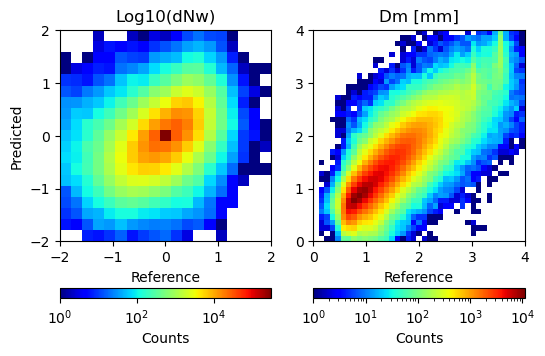

In [ ]:
plt.figure(figsize=(6,4))
ax=plt.subplot(121)
h2d=plt.hist2d(np.array(validL).flatten(),np.array(predL).flatten(),bins=np.linspace(-2,2,20),cmap='jet',norm=LogNorm())
print((np.array(predL).mean(),np.array(validL).mean()))
ax.set_aspect('equal')
plt.colorbar(h2d[-1],label='Counts',orientation='horizontal')
plt.xlabel('Reference')
plt.ylabel('Predicted')
plt.title('Log10(dNw)')
ax2=plt.subplot(122)
h2d_2=plt.hist2d(np.array(dm_refL).flatten(),np.array(dm_predL).flatten(),bins=[np.linspace(0,4,40),np.linspace(0,4,40)],cmap='jet',norm=LogNorm())
ax2.set_aspect('equal')
plt.xlabel('Reference')
plt.title('Dm [mm]')
plt.colorbar(h2d_2[-1],label='Counts',orientation='horizontal')
plt.tight_layout()
plt.savefig('logdNw_and_Dm.png',dpi=300)

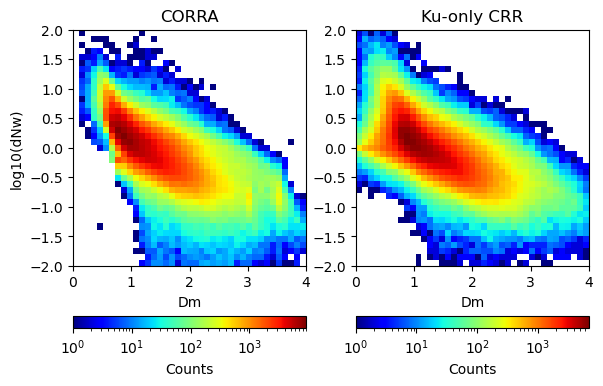

In [440]:

plt.figure(figsize=(6,4))
ax1=plt.subplot(122)
h2d_1=plt.hist2d(np.array(dm_predL).flatten(),np.array(nw_predL).flatten(),bins=[np.linspace(0,4,40),np.linspace(-2,2,40)],cmap='jet',norm=LogNorm())
plt.xlabel('Dm')
plt.title('Ku-only CRR')
plt.colorbar(h2d_1[-1],label='Counts',orientation='horizontal')
plt.ylim(-2,2)
ax1=plt.subplot(121)
plt.title('CORRA')
h2d_2=plt.hist2d(np.array(dm_refL).flatten(),np.array(nw_refL).flatten(),bins=[np.linspace(0,4,40),np.linspace(-2,2,40)],cmap='jet',norm=LogNorm())
plt.xlabel('Dm')
plt.ylabel('log10(dNw)')
plt.colorbar(h2d_2[-1],label='Counts',orientation='horizontal')
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig('logdNw_vs_Dm_CRR.png',dpi=300)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class LSTM_Gen_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size_seq):
        super(LSTM_Gen_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.1, batch_first=True)
        
        # Fully connected layer for sequence output
        self.fc_sequence = nn.Linear(hidden_size, output_size_seq)  
        
        # Fully connected layer for scalar output

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        #output = packed_output.data
        # Sequence prediction (for each time step)
        seq_output = self.fc_sequence(output)
        return seq_output
    
class LSTM_nearSfcPrecip_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_scalar_size, dropout=0.1):
        super(LSTM_nearSfcPrecip_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Fully connected layer for sequence output
        self.fc_sequence = nn.Linear(hidden_size, output_scalar_size)  
        
        # Fully connected layer for scalar output

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        #output = packed_output.data
        # Sequence prediction (for each time step)
        scalar_output = self.fc_sequence(hn[-1])
        return scalar_output
    
class LSTM_PrecipTot_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        super(LSTM_PrecipTot_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Fully connected layer for sequence output
        self.fc_sequence = nn.Linear(hidden_size, output_size)  
        
        # Fully connected layer for scalar output

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        #output = packed_output.data
        # Sequence prediction (for each time step)
        scalar_output = self.fc_sequence(output)
        return scalar_output
    
# Example usage:
batch_size = 3
seq_lengths = torch.tensor([4, 2, 1])  # Variable lengths of the sequences
input_size = 3
hidden_size = 10
num_layers = 2
output_size_seq = 1  # Sequence output size
output_size_scalar = 2  # Scalar output size



class Critic(nn.Module):  # Critic is the same as the Discriminator in LSGAN
    def __init__(self, input_dim, num_layers, hidden_dim):
        super(Critic, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, lengths):
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        return self.fc(hn).mean(dim=1) 




In [177]:

# Create a batch of padded inputs with variable lengths
padded_train_input = torch.tensor(x_train_padded, dtype=torch.float32)
seq_train_lengths = torch.tensor(n_seq_train, dtype=torch.int32)
seq_train_output_torch = torch.tensor(y_train_seq_padded, dtype=torch.float32)
scalar_train_output_torch = torch.tensor(y_train_scalar, dtype=torch.float32)

seq_val_lengths=torch.tensor(n_seq_val, dtype=torch.int32)
padded_val_input=torch.tensor(x_val_padded, dtype=torch.float32)
seq_val_output_torch=torch.tensor(y_val_seq_padded, dtype=torch.float32)
scalar_val_output_torch=torch.tensor(y_val_scalar, dtype=torch.float32)


In [256]:
nw_prof_model = LSTM_Gen_Model(input_size=2, hidden_size=16, num_layers=2, output_size_seq=1)
dataset = TensorDataset(padded_train_input, seq_train_output_torch, scalar_train_output_torch, seq_train_lengths)

epochs=4
batch_size=64
optimizer_nw = optim.Adam(nw_prof_model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

seq_loss_fn=nn.MSELoss(reduction='none')


In [263]:
for epoch in range(epochs):
    avg_loss = 0
    icount=0
    for i, (x_batch, y_seq_batch, y_scalar_batch, lengths) in enumerate(dataloader):
        # Forward pass

        nw_output =nw_prof_model(x_batch[:,:,:2], lengths)
        
        # Calculate loss
        nseq1=nw_output.size(1)
        x_prof=torch.cat((x_batch[:,:nseq1,:2],nw_output),dim=2)
        seq_output = precip_prof_model(x_prof, lengths)
        #print(seq_output.size())
        scal_loss = torch.sum(seq_loss_fn(seq_output, y_seq_batch[:,:nseq1,1:2]),dim=1)
        scal_loss = torch.div(scal_loss[:,0],lengths)
        #print(scal_loss.size())
        #break
        loss = scal_loss.mean()
        
        # Backward pass
        optimizer_nw.zero_grad()
        loss.backward()
        
        # Update weights
        optimizer_nw.step()
        avg_loss += loss.item()
        icount+=1
    
    print(f"Epoch {epoch}, Iteration {i}, Loss: {avg_loss/icount}")

Epoch 0, Iteration 792, Loss: 0.013691951811999496
Epoch 1, Iteration 792, Loss: 0.01290686387089545
Epoch 2, Iteration 792, Loss: 0.012709176154339787
Epoch 3, Iteration 792, Loss: 0.012618788433452648


In [192]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
output_size=1
precip_prof_model=LSTM_PrecipTot_Model(input_size, hidden_size, num_layers, output_size, dropout=0.05)

scalar_loss_fn=nn.MSELoss()
# Create a DataLoader
#padded_train_input = torch.tensor(x_train_padded, dtype=torch.float32)
#seq_train_lengths = torch.tensor(n_seq_train, dtype=torch.int32)
#seq_train_output_torch = torch.tensor(y_train_seq_padded, dtype=torch.float32)
#scalar_train_output_torch = torch.tensor(y_train_scalar, dtype=torch.float32)

dataset = TensorDataset(padded_train_input, seq_train_output_torch, scalar_train_output_torch, seq_train_lengths)

epochs=4
batch_size=64
optimizer_prof = optim.Adam(precip_prof_model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [265]:
seq_loss_fn=nn.MSELoss(reduction='none')
for epoch in range(epochs):
    avg_loss = 0
    icount=0
    for i, (x_batch, y_seq_batch, y_scalar_batch, lengths) in enumerate(dataloader):
        # Forward pass

        seq_output = precip_prof_model(x_batch[:,:,:3], lengths)
        
        # Calculate loss
        nseq1=seq_output.size(1)
        #print(seq_output.size(),y_seq_batch.size())
        #break
        scal_loss = torch.sum(seq_loss_fn(seq_output, y_seq_batch[:,:nseq1,1:2]),dim=1)
        scal_loss = torch.div(scal_loss[:,0],lengths)
        #print(scal_loss.size())
        #break
        loss = scal_loss.mean()
        
        # Backward pass
        optimizer_prof.zero_grad()
        loss.backward()
        
        # Update weights
        optimizer_prof.step()
        avg_loss += loss.item()
        icount+=1
    
    print(f"Epoch {epoch}, Iteration {i}, Loss: {avg_loss/icount}")

Epoch 0, Iteration 792, Loss: 0.003467888241454085
Epoch 1, Iteration 792, Loss: 0.003459985696060012
Epoch 2, Iteration 792, Loss: 0.003439370731994613
Epoch 3, Iteration 792, Loss: 0.003441639280963741


In [ ]:
#precip_prof_model_scripted = torch.jit.script(precip_prof_model)
#torch.jit.save(precip_prof_model_scripted, 'precip_prof_model.pt')

[[1.         0.95352816]
 [0.95352816 1.        ]]
6.046065 6.12340496446752
[[1.         0.98910906]
 [0.98910906 1.        ]]


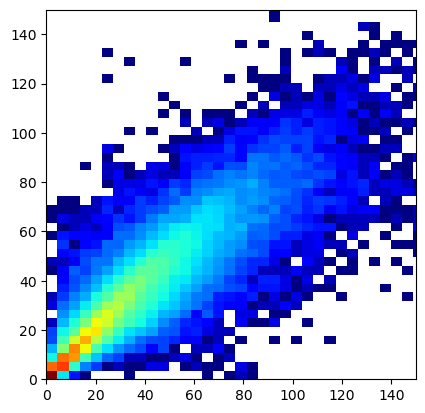

In [205]:
y_val_pred=precip_prof_model(padded_val_input[:,:,:3],seq_val_lengths)
y_val_pred_2=precip_prof_model(padded_val_input[:,:,:3],seq_val_lengths)

y1_2=[]
y1_1=[]
y2=[]
for i in range(y_val_pred_2.size(0)):
    nseq1=seq_val_lengths[i]
    y1_2.extend(0.1*(10**y_val_pred_2[i,:nseq1,0].detach().numpy()-1))
    y1_1.extend(0.1*(10**y_val_pred[i,:nseq1,0].detach().numpy()-1))
    y2.extend(0.1*(10**y_val_seq_padded[i,:nseq1,1]-1))
ax=plt.subplot(111)
h2d=plt.hist2d(y2,y1_2,bins=50,cmap='jet',norm=LogNorm())
plt.xlim(0,150)
plt.ylim(0,150)
ax.set_aspect('equal')
print(np.corrcoef(y1_2,y2))
print(np.mean(y1_2),np.mean(y2))
print(np.corrcoef(y1_1,y1_2))

[[1.         0.85569048]
 [0.85569048 1.        ]]
[[1.         0.97627794]
 [0.97627794 1.        ]]
5.5994806 6.12340496446752


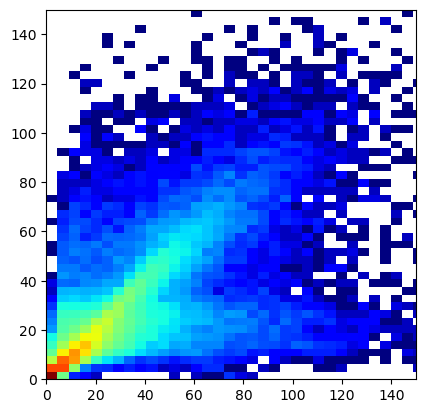

In [266]:
padded_val_input_clone=padded_val_input.detach().clone()
nt,nz,nf=padded_val_input_clone.size()
gen_nw=nw_prof_model(padded_val_input_clone[:,:,:2],seq_val_lengths)
nz1=gen_nw.size(1)
padded_val_input_clone[:,:nz1,2]=gen_nw[:,:nz1,0]
y_val_pred_1=precip_prof_model(padded_val_input_clone[:,:,:3],seq_val_lengths)


y1_new=[]
y2=[]
for i in range(y_val_pred_2.size(0)):
    nseq1=seq_val_lengths[i]
    y1_new.extend(0.1*(10**y_val_pred_1[i,:nseq1,0].detach().numpy()-1))
    y2.extend(0.1*(10**y_val_seq_padded[i,:nseq1,1]-1))
ax=plt.subplot(111)
h2d=plt.hist2d(y2,y1_new,bins=50,cmap='jet',norm=LogNorm())
plt.xlim(0,150)
plt.ylim(0,150)
ax.set_aspect('equal')
print(np.corrcoef(y1_new,y2))
print(np.corrcoef(y1,y1_new))
print(np.mean(y1_new),np.mean(y2))
#print(np.corrcoef(y1_1,y1_2))

In [48]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
output_size_scalar=2
precip_model=LSTM_nearSfcPrecip_Model(input_size, hidden_size, num_layers, output_size_scalar)
precip_model_noNw=LSTM_nearSfcPrecip_Model(input_size-1, hidden_size, num_layers, output_size_scalar)

scalar_loss_fn=nn.MSELoss()
# Create a DataLoader
dataset = TensorDataset(padded_input, seq_output_torch, scalar_output_torch, seq_lengths)

epochs=4
batch_size=64
optimizer = optim.Adam(precip_model.parameters(), lr=0.001)
optimizer_noNw = optim.Adam(precip_model_noNw.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [60]:

for epoch in range(3*epochs):
    avg_loss = 0
    icount=0
    for i, (x_batch, y_seq_batch, y_scalar_batch, lengths) in enumerate(dataloader):
        # Forward pass

        scalar_output = precip_model(x_batch[:,:,:3], lengths)
        
        # Calculate loss
       
        scal_loss = scalar_loss_fn(scalar_output, y_scalar_batch)
        loss = scal_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update weights
        optimizer.step()
        avg_loss += loss.item()
        icount+=1
    
    print(f"Epoch {epoch}, Iteration {i}, Loss: {avg_loss/icount}")

Epoch 0, Iteration 792, Loss: 0.10367427237360054
Epoch 1, Iteration 792, Loss: 0.02205342396537093
Epoch 2, Iteration 792, Loss: 0.01804580739587733
Epoch 3, Iteration 792, Loss: 0.01682052497539439
Epoch 4, Iteration 792, Loss: 0.015919489729069033
Epoch 5, Iteration 792, Loss: 0.01529704092785688
Epoch 6, Iteration 792, Loss: 0.014783507676896126
Epoch 7, Iteration 792, Loss: 0.014282868769604709
Epoch 8, Iteration 792, Loss: 0.013813850233239717
Epoch 9, Iteration 792, Loss: 0.013331481467575436
Epoch 10, Iteration 792, Loss: 0.012932410105489768
Epoch 11, Iteration 792, Loss: 0.012493329038984443


In [79]:
padded_val_input_grad=torch.tensor(x_val_padded[:,:,:3], dtype=torch.float32).requires_grad_(True)
scalar_out=precip_model(padded_val_input_grad[:,:,:],seq_val_lengths)
scalar_out.sum().backward()
# detach the gradient


In [84]:
grads = padded_val_input_grad.grad.detach().numpy()
print(grads.shape)
cfad_grads=np.zeros((50,grads.shape[1]))
for i,grad1 in enumerate(grads):
    for k in range(grads.shape[1]):
        ik=int(grad1[k,2]/0.01)+20
        if ik<0 or ik>49 or padded_val_input[i,k,3]<=0.1:
            continue
        cfad_grads[ik,k]+=1
        


(26130, 63, 3)


(62.0, 0.0)

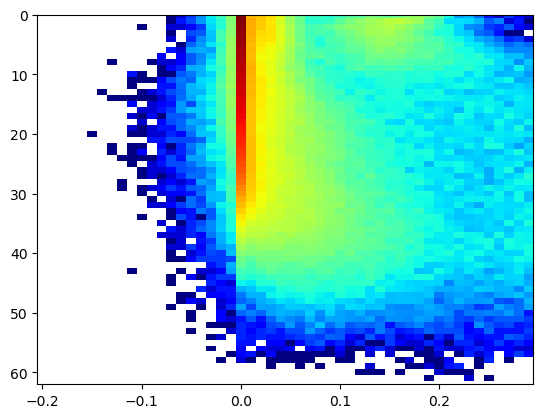

In [86]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure()
plt.pcolormesh(np.arange(-20,30)*0.01,np.arange(0,grads.shape[1]),cfad_grads.T,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.ylim(62,0)

In [ ]:
seq_loss_fn=nn.MSELoss()
for epoch in range(3*epochs):
    avg_loss = 0
    icount=0
    for i, (x_batch, y_seq_batch, y_scalar_batch, lengths) in enumerate(dataloader):
        # Forward pass

        seq_output = precip_model_noNw(x_batch[:,:,:2], lengths)
        
        # Calculate loss
        nz=seq_output.size(1)
        scal_loss = seq_loss_fn(seq_output, y_seq_batch[:,:nz,1:2])
        loss = scal_loss
        
        # Backward pass
        optimizer_prof_grad()
        loss.backward()
        
        # Update weights
        optimizer_prof.step()
        avg_loss += loss.item()
        icount+=1
    
    print(f"Epoch {epoch}, Iteration {i}, Loss: {avg_loss/icount}")

[[1.         0.98564649]
 [0.98564649 1.        ]]
5.290772 4.786743
0.9047344


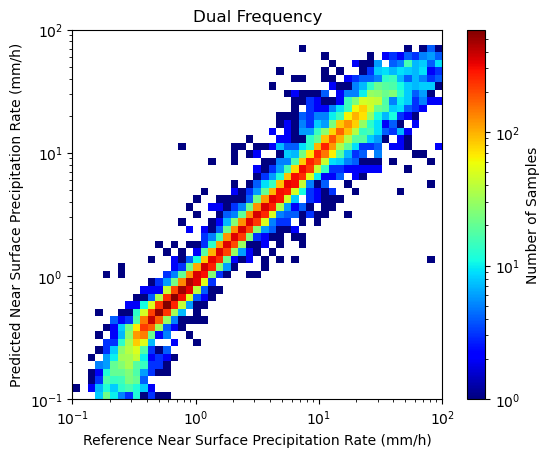

In [51]:
#output1 = precip_model(padded_val_input,seq_val_lengths)
scalar_output = output1
print(np.corrcoef(scalar_output[:,-1].detach().numpy().flatten(),scalar_val_output_torch[:,-1].flatten()))
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
ref_precip=0.1*(10**(scalar_val_output_torch[:,-1].detach().numpy().flatten())-1)
pred_precip=0.1*(10**(scalar_output[:,-1].detach().numpy().flatten())-1)
h1=plt.hist2d(ref_precip,pred_precip,bins=[np.logspace(-1,2,50),np.logspace(-1,2,50)],norm=LogNorm(),cmap='jet')
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(h1[3],label='Number of Samples')
plt.xlim(0.1,100)
plt.ylim(0.1,100)
ax.set_aspect('equal')
plt.ylabel('Predicted Near Surface Precipitation Rate (mm/h)')
plt.xlabel('Reference Near Surface Precipitation Rate (mm/h)')
print(np.mean(ref_precip),np.mean(pred_precip))
print(np.mean(pred_precip)/np.mean(ref_precip))
plt.title('Dual Frequency')
plt.tight_layout
plt.savefig('near_sfc_precip_rate_df.png',dpi=300)

[[1.         0.96821511]
 [0.96821511 1.        ]]
5.290772 4.8680964
0.92011076


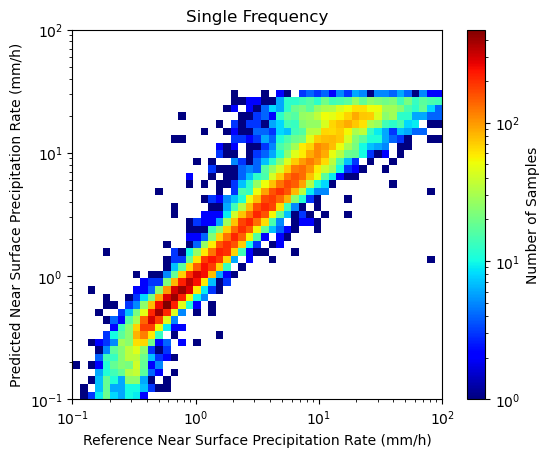

In [57]:
output_noNw = precip_model_noNw(padded_val_input[:,:,:-1],seq_val_lengths)
scalar_output = output_noNw
print(np.corrcoef(scalar_output[:,-1].detach().numpy().flatten(),scalar_val_output_torch[:,-1].flatten()))
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
ref_precip=0.1*(10**(scalar_val_output_torch[:,-1].detach().numpy().flatten())-1)
pred_precip=0.1*(10**(scalar_output[:,-1].detach().numpy().flatten())-1)
h1=plt.hist2d(ref_precip,pred_precip,bins=[np.logspace(-1,2,50),np.logspace(-1,2,50)],norm=LogNorm(),cmap='jet')
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(h1[3],label='Number of Samples')
plt.xlim(0.1,100)
plt.ylim(0.1,100)
ax.set_aspect('equal')
plt.ylabel('Predicted Near Surface Precipitation Rate (mm/h)')
plt.xlabel('Reference Near Surface Precipitation Rate (mm/h)')
print(np.mean(ref_precip),np.mean(pred_precip))
print(np.mean(pred_precip)/np.mean(ref_precip))
plt.title('Single Frequency')
plt.tight_layout
plt.savefig('near_sfc_precip_rate_noNw.png',dpi=300)

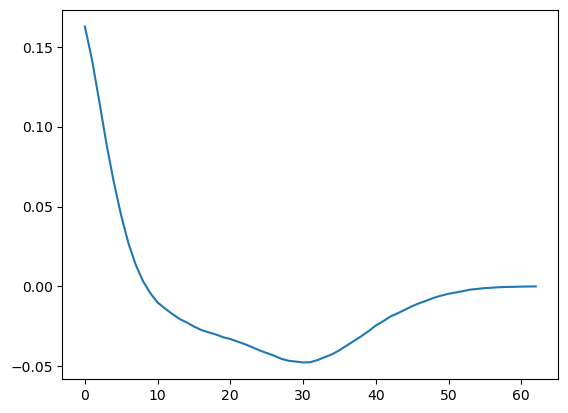

In [53]:
import matplotlib.pyplot as plt
plt.plot(y_train_seq_padded[:,:,0].mean(axis=0))
#plt.plot(x_train_padded[:,:,1].mean(axis=0))
#print(x_train_padded[:,:,0].mean(axis=0))


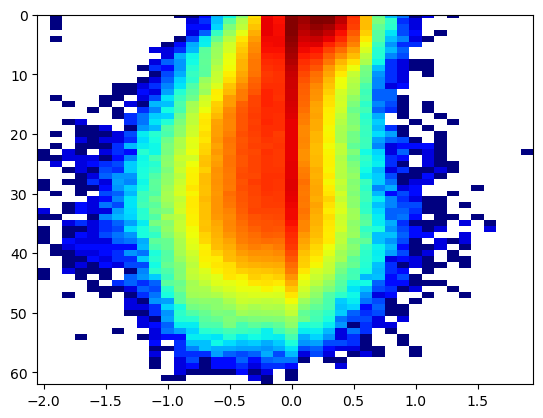

In [59]:

nw_cfad=np.zeros((40,63))

for i in range(x_train_padded.shape[0]):
    for k in range(0,n_seq_train[i]):
        ik=int(y_train_seq_padded[i,k,0]/0.1)+20
        if ik>=0 and ik<40 and x_train_padded[i,k,1]>0.0:
            nw_cfad[ik,k]+=1

from matplotlib.colors import LogNorm
plt.pcolormesh((-20+np.arange(40))*0.1,range(63),nw_cfad.T,cmap='jet',norm=LogNorm())
plt.ylim(62,0)

seq_train_pred,scalar_train_pred,hn_train_pred=model(padded_input,seq_lengths)

In [100]:
seq_train_pred_detached=seq_train_pred.detach().numpy()
scalar_train_pred_detached=scalar_train_pred.detach().numpy()
seq_val_pred,scalar_val_pred,hn_val_pred=model(padded_val_input,seq_val_lengths)
seq_val_pred_detached=seq_val_pred.detach().numpy()
scalar_val_pred_detached=scalar_val_pred.detach().numpy()

error_train_seq=[]
error_train_scalar=[]

error_val_seq=[]
error_val_scalar=[]
nvals=20
for i in range(x_train_padded.shape[0]):
    if n_seq_train[i]>nvals:
        nbot=n_seq_train[i]
        y_tmp=list()
        #y_tmp.extend(list(x_train_padded[i,nbot-nvals:nbot,0]))
        y_tmp.extend(y_train_scalar[i,:]-scalar_train_pred_detached[i,:])
        error_train_seq.append(y_tmp)
        error_train_scalar.append(y_train_seq_padded[i,nbot-nvals:nbot,0]-seq_train_pred_detached[i,nbot-nvals:nbot,0])

for i in range(x_val_padded.shape[0]):
    if n_seq_val[i]>nvals:
        nbot=n_seq_val[i]
        y_tmp=list()
        #y_tmp.extend(list(x_val_padded[i,nbot-nvals:nbot,0]))
        y_tmp.extend(y_val_scalar[i,:]-scalar_val_pred_detached[i,:])
        error_val_seq.append(y_tmp)
        error_val_scalar.append(y_val_seq_padded[i,nbot-nvals:nbot,0]-seq_val_pred_detached[i,nbot-nvals:nbot,0])
        #y_val_scalar[i,:]-scalar_val_pred_detached[i,:])

print(len(error_train_seq),x_train_padded.shape[0],len(error_val_seq),x_val_padded.shape[0]) 
error_train_seq=np.array(error_train_seq)
error_train_scalar=np.array(error_train_scalar)
error_val_seq=np.array(error_val_seq)
error_val_scalar=np.array(error_val_scalar)

print(error_val_scalar.shape)
print(error_train_scalar.shape)
print(error_val_seq.shape)
print(error_train_seq.shape)
#print(eps1.shape,eps1_scalar.shape)
#print(np.corrcoef(eps1[:],eps1_scalar))

21494 50738 11133 26130
(11133, 20)
(21494, 20)
(11133, 2)
(21494, 2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        out, _ = self.lstm(z)
        return self.fc(out)

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out).mean(dim=1)

def gradient_penalty(critic, real_data, fake_data):
    batch_size, _ = real_data.size()
    epsilon = torch.rand(batch_size, 1).to(real_data.device)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    critic_interpolated = critic(interpolated)
    grad_outputs = torch.ones_like(critic_interpolated)
    gradients = torch.autograd.grad(
        outputs=critic_interpolated,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty

# Define hyperparameters
input_dim = 10  # Example input dimensions for noise
hidden_dim = 50
output_dim = 1
lr = 1e-4

# Initialize models and optimizers
generator = Generator(input_dim, hidden_dim, output_dim).to(device)
critic = Critic(output_dim, hidden_dim).to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_C = optim.Adam(critic.parameters(), lr=lr)

# Training loop outline
for epoch in range(num_epochs):
    for i, (real_deviation) in enumerate(data_loader):
        # Critic update
        for _ in range(critic_updates_per_generator):
            optimizer_C.zero_grad()
            z = torch.randn(batch_size, seq_len, input_dim).to(device)
            fake_deviation = generator(z)
            critic_real = critic(real_deviation)
            critic_fake = critic(fake_deviation)
            gp = gradient_penalty(critic, real_deviation, fake_deviation)
            loss_C = -(critic_real.mean() - critic_fake.mean()) + lambda_gp * gp
            loss_C.backward()
            optimizer_C.step()
        
        # Generator update
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, seq_len, input_dim).to(device)
        fake_deviation = generator(z)
        loss_G = -critic(fake_deviation).mean()
        loss_G.backward()
        optimizer_G.step()


In [101]:
from sklearn.neighbors import KNeighborsRegressor

knn=KNeighborsRegressor(n_neighbors=25)
#error_train_scalar=np.array(error_train_scalar)
knn.fit(error_train_seq,error_train_scalar)
error_val_scalar_pred=knn.predict(error_val_seq)
#print(error_val_scalar_pred)
error_val_scalar_pred=np.array(error_val_scalar_pred)
print(error_val_scalar.shape)
print(np.corrcoef(error_val_scalar_pred[:,:].flatten(),error_val_scalar[:,:].flatten()))
#print(np.corrcoef(error_val_scalar_pred[:,1],error_val_scalar[:,1]))

(11133, 20)
[[1.         0.43383692]
 [0.43383692 1.        ]]


[0.56301272 0.76777968 0.86782919 0.91836894 0.94770578 0.96415525]
[[1.         0.33708932]
 [0.33708932 1.        ]]
[[1.         0.34976539]
 [0.34976539 1.        ]]


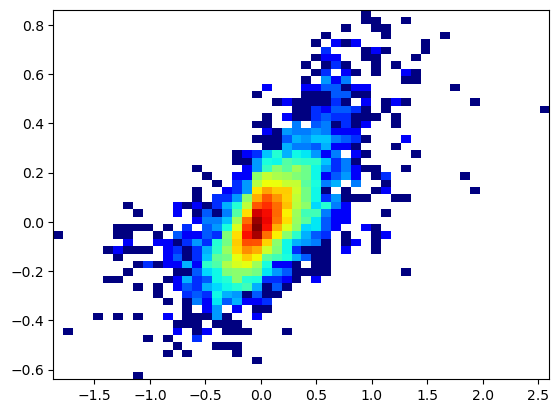

In [ ]:
x_val_cat=np.concatenate((error_val_seq,error_val_scalar_pred),axis=1)
from sklearn.decomposition import PCA

pca=PCA(n_components=0.95)
pca.fit(error_train_seq)
pcs=pca.transform(error_train_seq)
print(pca.explained_variance_ratio_.cumsum())
plt.hist2d(error_val_scalar[:,0],error_val_scalar_pred[:,0],bins=50,cmap='jet',norm=LogNorm())
print(np.corrcoef(pcs[:,1],error_train_scalar[:,0]))
print(np.corrcoef(pcs[:,1],error_train_scalar[:,1]))

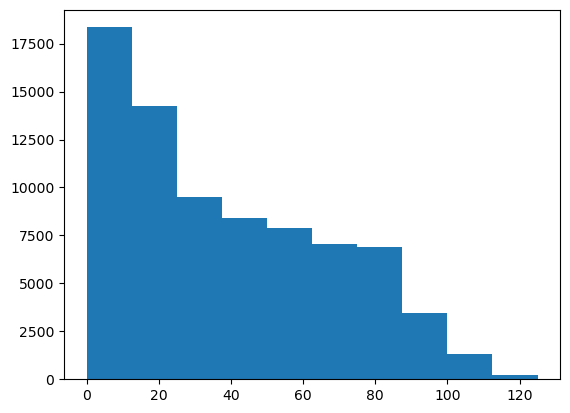

In [3]:
import matplotlib.pyplot as plt
h1=plt.hist(n_bins_L)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class LSTMPackedGMMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim, n_components, rank, scalar_dim):
        super(LSTMPackedGMMModel, self).__init__()
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        
        # Fully connected layers to produce GMM parameters
        self.fc_means = nn.Linear(hidden_size, n_components * output_dim)
        self.fc_diag_vars = nn.Linear(hidden_size, n_components * output_dim)
        self.fc_lowrank_factors = nn.Linear(hidden_size, n_components * output_dim * rank)
        self.fc_weights = nn.Linear(hidden_size, n_components)
        
        self.fc_scalar_means = nn.Linear(hidden_size, scalar_dim*n_components)
        self.fc_scalar_diag_vars = nn.Linear(hidden_size, scalar_dim*n_components)
        self.fc_scalar_lowrank_factors = nn.Linear(hidden_size, scalar_dim*n_components*rank)

        # Store dimensions
        self.output_dim = output_dim
        self.n_components = n_components
        self.rank = rank
        self.scalar_dim = scalar_dim

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Predict GMM parameters
        batch_size, seq_len, _ = output.size()
        
        # Means for each component
        means = self.fc_means(output).view(batch_size, seq_len, self.n_components, self.output_dim)
        
        # Diagonal variances (ensure positivity with softplus or another non-negative activation)
        diag_vars = F.softplus(self.fc_diag_vars(output)).view(batch_size, seq_len, self.n_components, self.output_dim)
        
        # Low-rank factors for each component
        lowrank_factors = self.fc_lowrank_factors(output).view(batch_size, seq_len, self.n_components, self.output_dim, self.rank)
        
        # Mixture weights (apply softmax to ensure they sum to 1)
        weights = F.softmax(self.fc_weights(output), dim=-1).view(batch_size, seq_len, self.n_components)

        # predict scalar values and uncertainties from the last hidden state

        scalar_means = self.fc_scalar_means(hn[0]).view(batch_size, self.n_components, self.scalar_dim)
        scalar_diag_vars = F.softplus(self.fc_scalar_diag_vars(hn[0])).view(batch_size, self.n_components, self.scalar_dim)
        scalar_lowrank_factors = self.fc_scalar_lowrank_factors(hn[0]).view(batch_size, self.n_components, self.scalar_dim, self.rank)
        
        return means, diag_vars, lowrank_factors, weights, scalar_means, scalar_diag_vars, scalar_lowrank_factors
